In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("tf version:",tf.__version__)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
import os 
import sys
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

tf version: 2.9.0


In [2]:
dfss = pd.read_parquet(r"D:\RND\Machine_Learning\Datasets/clean_dataset_ml_100_id.parquet")
dfss.fillna(0,inplace=True)
df = dfss.copy()
# df = df[df['label_sensor_id']==1]
df['creation_time'] = pd.to_datetime(df['creation_time'])
df.set_index(['creation_time'],drop= True, inplace= True)
# df["min"] = df.index.minute
df.sort_index(inplace=True)
df.reset_index(drop=True,inplace=True)
df

,temperature_2m,relative_humidity_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,consumed_unit,lag1,lag2,lag3,lag4,lag5,day,hour,month,dayofweek,dayofyear,label_sensor_id
0,12.1,95,10.8,11.4,21.6,0.00,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,0
1,8.4,93,6.0,11.9,22.7,6.48,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,72
2,8.5,92,5.5,15.6,28.3,0.50,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,71
3,12.1,95,10.9,11.4,21.6,0.00,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,4
4,8.4,92,5.7,13.6,25.7,0.10,0.0,0.00,0.0,0.00,0.0,1,0,1,0,1,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461121,18.5,37,14.4,17.7,31.1,0.50,0.5,0.50,14.0,11.00,0.0,25,23,2,6,56,38
461122,18.0,35,13.9,16.7,29.1,3.06,2.0,3.06,1.0,3.00,2.0,25,23,2,6,56,37
461123,16.9,33,12.8,14.1,25.3,2.00,2.0,2.00,2.0,8.97,2.0,25,23,2,6,56,36
461124,18.0,43,14.9,13.5,25.5,0.00,0.0,0.00,0.0,0.00,0.0,25,23,2,6,56,60


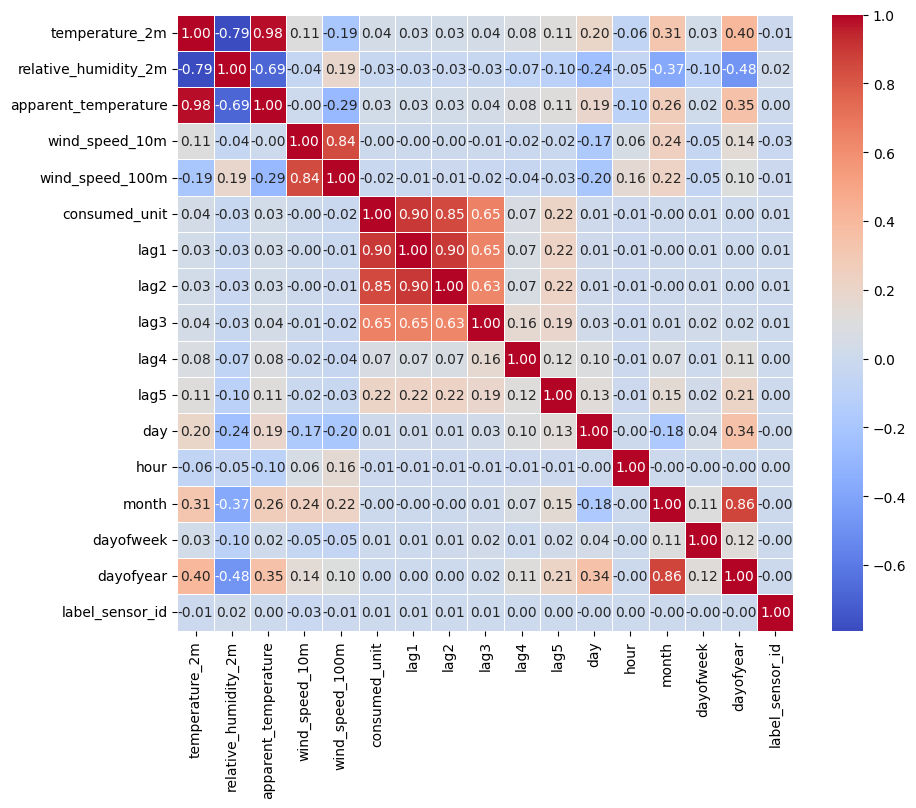

In [3]:
correlation_matrix = df.corr()
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
# Show the plot
plt.show()

In [4]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)]
# val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
print("train_df:",len(train_df),"val_df","len(val_df)","test_df:",len(test_df))
# num_features = df.shape[1]
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('consumed_unit')
test_labels = test_features.pop('consumed_unit')

# # val_features = val_df.copy()
# val_labels = val_features.pop('consumed_unit')


train_df: 415013 val_df len(val_df) test_df: 46113


In [5]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [6]:
# df.describe().transpose()
train_features.describe()[1:3]

,temperature_2m,relative_humidity_2m,apparent_temperature,wind_speed_10m,wind_speed_100m,lag1,lag2,lag3,lag4,lag5,day,hour,month,dayofweek,dayofyear,label_sensor_id
mean,16.736779,51.874674,14.189841,10.895915,17.312715,2.144219,2.14377,2.103014,1.844367,1.504121,13.758933,11.451311,1.383518,2.927995,25.647994,51.040611
std,5.549577,21.928665,5.672845,4.702054,7.937159,3.844408,3.84411,3.817844,3.652374,3.386129,8.325175,6.931398,0.486243,2.022607,14.514304,29.384169


In [11]:
# first = np.array(train_features[:1])
# with np.printoptions(precision=2, suppress=True):
#     print('First example:', first)
#     print('Normalized:', normalizer(first).numpy())

In [ ]:
test_results={}


In [7]:


# Create a callback that saves the model's weights
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
def compile_and_fit(model,
                    train_features = train_features,
                    train_labels = train_labels, 
                    patience=5,
                    batch_size = None,
                    MAX_EPOCHS = 100):
        
    # checkpoint_path = "training_1/cp.ckpt"
    # checkpoint_dir = os.path.dirname(checkpoint_path)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min',
                                                        restore_best_weights=True)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=tf.keras.optimizers.Adam(0.0001),
                    metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(train_features,train_labels, epochs=MAX_EPOCHS,
                        validation_split=0.2,
                        callbacks=[early_stopping, cp_callback],  # Combine callbacks in a single list
                        verbose=1,
                        )
           
    return history, model


In [ ]:
os.listdir(checkpoint_dir)


In [8]:
"""simple_version"""
# model = keras.Sequential([
#       normalizer,
#       layers.Dense(64, activation='relu',input_shape=(16,)),
#       layers.Dense(32, activation='relu'),
#       layers.Dense(16, activation='relu'),
#       layers.Dense(1)])

""" sequential better version"""
input_shape = (16,)
# model = keras.Sequential([
#     normalizer,
#     layers.Dense(64, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dense(1)
# ])
"""lstm basic version"""
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Normalization(axis=-1, input_shape=input_shape),
#     tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.LSTM(64, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1)
# ])

"""lstm better version"""
# Reshape data for LSTM
train_features_array = train_features.to_numpy()
test_features_array = test_features.to_numpy()
n_timesteps = 1  # Each sample has 1 timestep (since features are already lagged)
n_features = 16  # Number of features

X_train = train_features_array.reshape((train_features.shape[0], n_timesteps, n_features))
X_test = test_features_array.reshape((test_features.shape[0], n_timesteps, n_features))

# Define LSTM model
model = Sequential([
    layers.LSTM(64, activation='relu', input_shape=(n_timesteps, n_features), return_sequences=True, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),  # Dropout to reduce overfitting
    layers.LSTM(32, activation='relu', return_sequences=False, kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])



In [9]:
history,model = compile_and_fit(model,train_features,train_labels,batch_size= 16)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1, 16), found shape=(None, 16)


In [10]:
def compile_and_fit(model,
                    train_features,
                    train_labels, 
                    patience=5,
                    batch_size=None,
                    MAX_EPOCHS=100):
        
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        restore_best_weights=True
    )
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(0.0001),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    history = model.fit(
        train_features,
        train_labels,
        epochs=MAX_EPOCHS,
        validation_split=0.2,
        callbacks=[early_stopping, cp_callback],
        verbose=1,
        batch_size=batch_size  # Ensure batch_size is passed if needed
    )
           
    return history, model

history, model = compile_and_fit(model, train_features=X_train, train_labels=train_labels, batch_size=16)


Epoch 1/100
20739/20751 [============================>.] - ETA: 0s - loss: 4.0426 - mean_absolute_error: 0.9924
Epoch 1: saving model to training_1\cp.ckpt
20751/20751 [==============================] - 46s 2ms/step - loss: 4.0412 - mean_absolute_error: 0.9922 - val_loss: 2.6759 - val_mean_absolute_error: 0.8150
Epoch 2/100
20744/20751 [============================>.] - ETA: 0s - loss: 3.0411 - mean_absolute_error: 0.7737
Epoch 2: saving model to training_1\cp.ckpt
20751/20751 [==============================] - 55s 3ms/step - loss: 3.0404 - mean_absolute_error: 0.7736 - val_loss: 2.6806 - val_mean_absolute_error: 0.7879
Epoch 3/100
20750/20751 [============================>.] - ETA: 0s - loss: 2.9220 - mean_absolute_error: 0.7382
Epoch 3: saving model to training_1\cp.ckpt
20751/20751 [==============================] - 58s 3ms/step - loss: 2.9220 - mean_absolute_error: 0.7382 - val_loss: 3.1816 - val_mean_absolute_error: 0.9111
Epoch 4/100
20749/20751 [============================>.] -

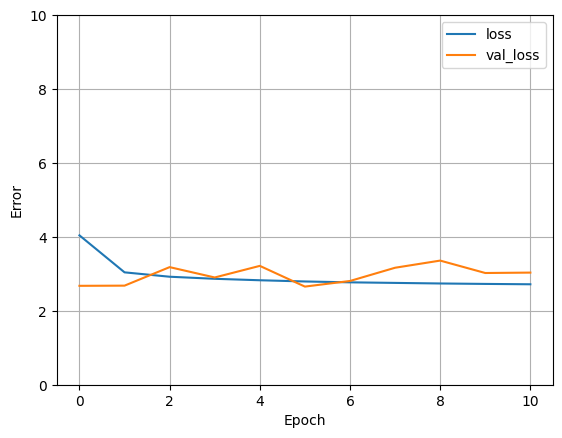

In [11]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
  
plot_loss(history)

In [12]:

# Evaluate the model
loss, acc = model.evaluate(test_features, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

ValueError: in user code:

    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1499, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\HARSH\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1, 16), found shape=(None, 16)


In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_features, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [13]:
def training_score(history):
    print(f"training_score:loss:{history.history['loss'][-1]:.3f},mae:{history.history['mean_absolute_error'][-1]:.3f}")

In [ ]:
def evaluate(model,test_features= test_features,test_labels= test_labels):
    score = model.evaluate(val_features,val_labels,verbose=0)
    print("val_score:",score)
    return score
training_score(history)
# score = evaluate(model)    

In [ ]:
def prediction(model, input_data,input_labels=None,verbose=1):
    y_pred = model.predict(input_data,verbose)
    mae = mean_absolute_error(input_labels, y_pred)
    mse = mean_squared_error(input_labels, y_pred)
    r2 = r2_score(input_labels, y_pred)
    print(f"mae: {mae:.3f}")
    print(f"mse: {mse:.3f}")
    print(f"R2: {r2:.3f}")
    return y_pred
predicted_value = prediction(model,input_data=test_features,input_labels=test_labels)

In [ ]:
x = np.arange(len(predicted_value))
# start = 40
values = 50
x = np.arange(values)
plt.scatter(x, predicted_value[:values], label='Predicted Values')
plt.scatter(x, test_labels[:values], label='Actual Values', color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Predicted vs. Actual Values')
plt.legend()
plt.show()


In [ ]:
first_dense_layer = model.layers[1]  
weights, biases = first_dense_layer.get_weights()
print("Weights shape:", weights.shape)
feature_importance = np.abs(weights).mean(axis=1)
for i, importance in enumerate(feature_importance):
    print(f"Feature {train_features.columns[i]}: Importance {importance}")

In [ ]:
def custom_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)
result = permutation_importance(model, test_features, test_labels, 
                                n_repeats=10, random_state=42, 
                                scoring=custom_scorer,
                                verbose=1)
sorted_idx = result.importances_mean.argsort()
for i in sorted_idx[::-1]:
    print(f"Feature {train_features.columns[i]}: Importance {result.importances_mean[i]:.8f}")

In [42]:

# Save the entire model as a `.keras` zip archive.
model.save('load_forecasting_lstm_model.keras')

In [ ]:
new_model = tf.keras.models.load_model('load_forecasting_model.keras')

# Show the model architecture
new_model.summary()

In [44]:

model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu',input_shape=(17,)),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)])

model.compile(loss='mean_absolute_error',
      # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
      optimizer=tf.keras.optimizers.Adam(0.001),
      metrics=['mean_squared_error',])


## with SGD

In [ ]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)

### with adam

In [ ]:
history = model.fit(train_features, train_labels, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
model.summary()